### **Import Libraries**
In this section, we will set up the necessary libraries for data processing, visualization, and model building. We will use `pandas` for data manipulation, `matplotlib` and `seaborn` for visualization, and various machine learning libraries for building and evaluating models. Additionally, we will include tools for handling class imbalance and saving models to disk.


In [ ]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from catboost import CatBoostClassifier
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
import pickle
import os


### **Data Processing and Preparation**

In this section, we undertook a series of steps to process and prepare our dataset for further analysis and modeling. 

1. **Data Initialization**:
   We began by initializing the data processor with the path to the CSV file containing our dataset. This step involved reading the dataset into a pandas DataFrame for subsequent processing.

2. **Data Examination**:
   We checked the DataFrame to understand its structure and content. This included calculating the percentage of missing values, determining the number of unique values in each column, and identifying the data types. This examination provided insights into the quality of the data and highlighted any potential issues that needed addressing.

3. **Data Cleaning**:
   We proceeded with cleaning the dataset to ensure it was ready for analysis. The cleaning process included:
   - **Removing Unnecessary Columns**: Specifically, we dropped the `LoanID` column as it was deemed unnecessary for our analysis.
   - **Encoding Categorical Variables**: We transformed categorical columns into numeric format using integer encoding. This step was essential for enabling machine learning algorithms to process categorical features.

4. **Data Export**:
   After cleaning and encoding the data, we saved the processed dataset to a new CSV file. Additionally, we created and saved a JSON file that contained the mapping of original categorical values to their integer codes. This JSON file facilitates the decoding of categorical values if needed in the future.


In [1]:


class DataProcessor:
    def __init__(self, file_path: str):
        """
        Initialize the DataProcessor with the path to the CSV file.
        
        Args:
        file_path (str): Path to the input CSV file.
        """
        self.file_path = file_path
        self.df = pd.read_csv(file_path)
    
    def check_dataframe_info(self) -> pd.DataFrame:
        """
        Check the percentage of missing values, number of unique values,
        and basic info of the DataFrame and return it as a pandas DataFrame.
        
        Returns:
        pd.DataFrame: A DataFrame containing percentage of missing values, number of unique values,
                      and data type information for each column.
        """
        # List to store the results
        results = []
        
        # Get the number of rows in the DataFrame
        num_rows = self.df.shape[0]
        
        # Loop through each column in the DataFrame
        for col in self.df.columns:
            # Calculate the percentage of missing values
            missing_percentage = self.df[col].isnull().sum() / num_rows * 100
            
            # Get the number of unique values
            unique_count = self.df[col].nunique()
            
            # Get the data type of the column
            dtype = str(self.df[col].dtype)  # Convert dtype to string for display
            
            # Append results to the list
            results.append({
                'Column': col,
                'Missing Percentage': f"{missing_percentage:.2f}%",
                'Unique Values': unique_count,
                'Data Type': dtype
            })
        
        # Create a DataFrame from the results
        result_df = pd.DataFrame(results)
        
        # Print the overall DataFrame info
        print("DataFrame Info:")
        print(f"Number of rows: {num_rows}")
        print(f"Number of columns: {len(self.df.columns)}")
        print()
        
        # Print the result DataFrame
        print(result_df.to_string(index=False))
        
        return result_df
    
    def clean_data(self, output_file_path: str, json_file_path: str):
        """
        Clean the dataset by dropping the LoanID column, encoding categorical columns,
        and saving the result to a new CSV file and a JSON map for encoding.
        
        Args:
        output_file_path (str): Path to save the preprocessed CSV file.
        json_file_path (str): Path to save the JSON encoding map.
        """
        # Drop the LoanID column
        if 'LoanID' in self.df.columns:
            self.df.drop(columns='LoanID', inplace=True)
        
        # Initialize a dictionary for categorical column encoding
        encoding_map = {}
        
        # Identify object (categorical) columns
        for col in self.df.select_dtypes(include=['object']).columns:
            # Create a mapping from category to integer
            codes, categories = pd.factorize(self.df[col])
            self.df[col] = codes
            encoding_map[col] = dict(enumerate(categories))
        
        # Save the DataFrame to a new CSV file
        self.df.to_csv(output_file_path, index=False)
        
        # Save the encoding map to a JSON file
        with open(json_file_path, 'w') as f:
            json.dump(encoding_map, f, indent=4)
        
        # Print a confirmation message
        print(f"Preprocessed data saved to {output_file_path}")
        print(f"Encoding map saved to {json_file_path}")



In [6]:

if __name__ == "__main__":
    # Define file paths
    input_file_path = 'data/loans.csv'
    output_file_path = 'data/loans_cleaned.csv'
    json_file_path = 'data/encoding_map.json'
    
    # Create a DataProcessor instance
    processor = DataProcessor(input_file_path)
    

In [7]:
# Check DataFrame info
processor.check_dataframe_info()

DataFrame Info:
Number of rows: 255347
Number of columns: 18

        Column Missing Percentage  Unique Values Data Type
        LoanID              0.00%         255347    object
           Age              0.00%             52     int64
        Income              0.00%         114620     int64
    LoanAmount              0.00%         158729     int64
   CreditScore              0.00%            550     int64
MonthsEmployed              0.00%            120     int64
NumCreditLines              0.00%              4     int64
  InterestRate              0.00%           2301   float64
      LoanTerm              0.00%              5     int64
      DTIRatio              0.00%             81   float64
     Education              0.00%              4    object
EmploymentType              0.00%              4    object
 MaritalStatus              0.00%              3    object
   HasMortgage              0.00%              2    object
 HasDependents              0.00%              2    o

,Column,Missing Percentage,Unique Values,Data Type
0,LoanID,0.00%,255347,object
1,Age,0.00%,52,int64
2,Income,0.00%,114620,int64
3,LoanAmount,0.00%,158729,int64
4,CreditScore,0.00%,550,int64
5,MonthsEmployed,0.00%,120,int64
6,NumCreditLines,0.00%,4,int64
7,InterestRate,0.00%,2301,float64
8,LoanTerm,0.00%,5,int64
9,DTIRatio,0.00%,81,float64


### Observations

The output provides a detailed overview of the dataset, including the number of rows, columns, and key characteristics of each column. Here’s a breakdown of the information:

#### General Overview

- **Number of Rows**: 255,347
- **Number of Columns**: 18

This indicates that the dataset contains 255,347 individual records and 18 attributes (columns).

#### Column Details

Each column in the DataFrame is described with the following attributes:

1. **Missing Percentage**: Indicates the proportion of missing values in the column. In this case, all columns have 0.00% missing values, meaning there are no missing values in any of the columns.

2. **Unique Values**: Shows the number of unique values present in each column. This helps understand the diversity of data within the column.

3. **Data Type**: Specifies the data type of each column, which can be useful for understanding how to process the data. Common data types include:
   - **object**: Typically used for categorical data or strings.
   - **int64**: Integer values.
   - **float64**: Floating-point numbers.

#### Column-Specific Insights

- **LoanID**: A unique identifier for each loan, with 255,347 unique values, indicating no duplicates.
- **Age**: Integer values with 52 unique ages, suggesting a range of ages among the records.
- **Income**: Integer values with 114,620 unique values, indicating significant variation in income levels.
- **LoanAmount**: Integer values with 158,729 unique values, showing diverse loan amounts.
- **CreditScore**: Integer values with 550 unique scores, reflecting a wide range of credit scores.
- **MonthsEmployed**: Integer values with 120 unique values, indicating various lengths of employment.
- **NumCreditLines**: Integer values with 4 unique values, showing a limited range of credit lines.
- **InterestRate**: Floating-point values with 2,301 unique rates, reflecting a broad range of interest rates.
- **LoanTerm**: Integer values with 5 unique terms, representing different loan durations.
- **DTIRatio**: Floating-point values with 81 unique ratios, showing a range of Debt-to-Income ratios.

**Categorical Columns** (Data Type: `object`):
- **Education**: 4 unique categories (e.g., different levels of education).
- **EmploymentType**: 4 unique categories (e.g., various types of employment).
- **MaritalStatus**: 3 unique categories (e.g., different marital statuses).
- **HasMortgage**: 2 unique values (e.g., yes/no).
- **HasDependents**: 2 unique values (e.g., yes/no).
- **LoanPurpose**: 5 unique categories (e.g., different reasons for the loan).
- **HasCoSigner**: 2 unique values (e.g., yes/no).

**Target Column**:
- **Default**: Integer values with 2 unique values, which likely represents a binary outcome indicating whether a loan has defaulted or not.


In [8]:
# Clean the data
processor.clean_data(output_file_path, json_file_path)

Preprocessed data saved to data/loans_cleaned.csv
Encoding map saved to data/encoding_map.json


### Exploratory Data Analysis (EDA) Process

In this section, we conducted an exploratory data analysis (EDA) to better understand the dataset and identify key characteristics and potential issues. Here’s an overview of the process and its objectives:

1. **Initialization**:
   We initialized the EDA process by loading the cleaned dataset from a CSV file and the categorical encoding map from a JSON file. This setup allowed us to work with the preprocessed data and utilize the encoding information for categorical variables.

2. **Univariate Analysis**:
   We performed univariate analysis to explore the distribution and characteristics of individual variables. This analysis was divided into:
   - **Continuous Variables**: For numerical columns with more than 10 unique values, we generated histograms and boxplots. Histograms provided insights into the distribution of values, while boxplots helped identify outliers and the spread of data.
   - **Discrete Variables**: For numerical columns with 10 or fewer unique values, we used count plots to visualize the frequency of each category. This helped us understand the distribution of categorical data represented numerically.

3. **Variance Inflation Factor (VIF) Calculation**:
   We calculated the Variance Inflation Factor (VIF) to assess multicollinearity among numerical features. High VIF values indicate that a feature is highly correlated with other features, which can lead to multicollinearity issues. By identifying features with high VIF values, we can make informed decisions about feature selection and potential adjustments.

4. **Bivariate Analysis**:
   We conducted bivariate analysis by calculating and visualizing the correlation matrix for numerical variables. The correlation heatmap showed the relationships between pairs of features, helping us identify strongly correlated variables. This is crucial for understanding how features interact with each other and for detecting potential multicollinearity.

5. **Preprocessing and Comprehensive Analysis**:
   The `preprocess_and_analyze` method combined the univariate and bivariate analyses with VIF calculations. This comprehensive analysis provided a holistic view of the dataset, highlighting both individual feature characteristics and inter-feature relationships.


Continuous Variables Analysis:


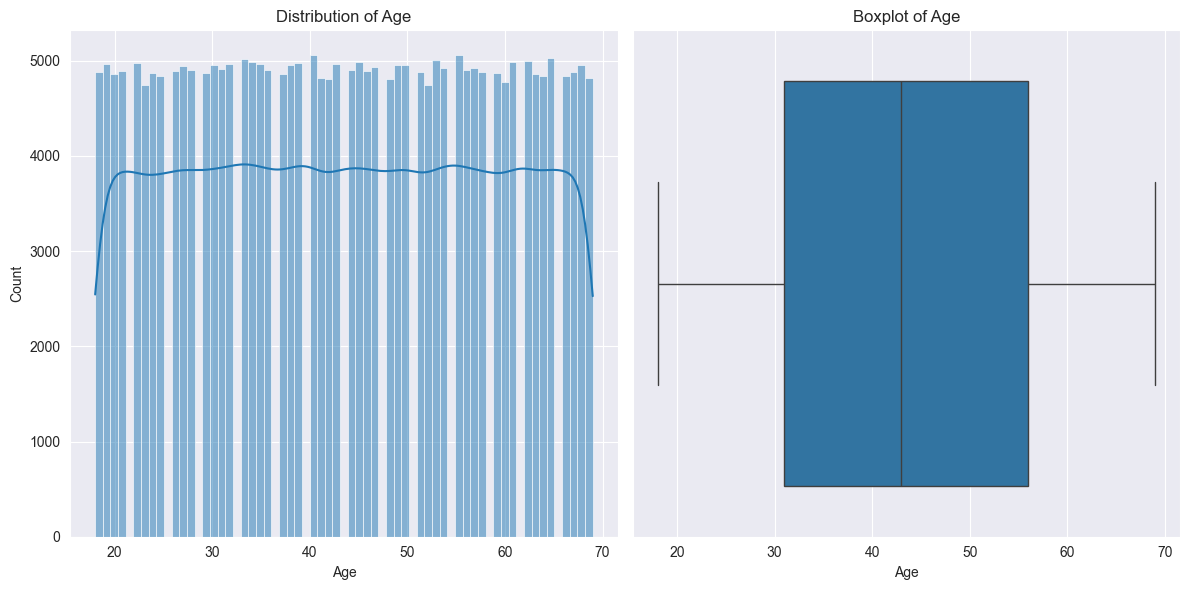

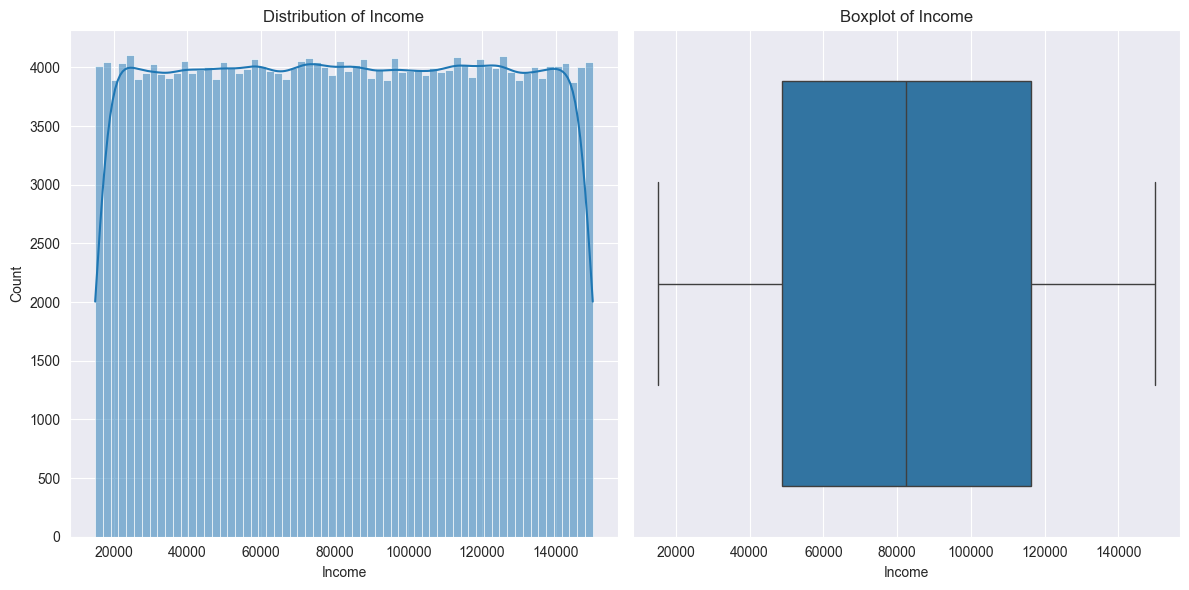

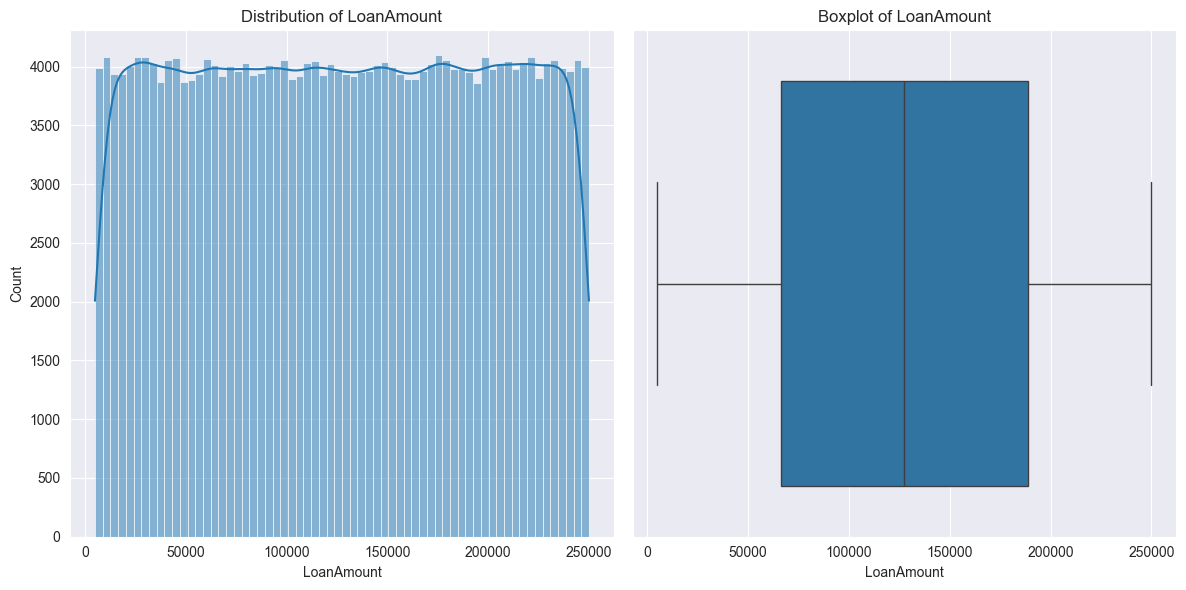

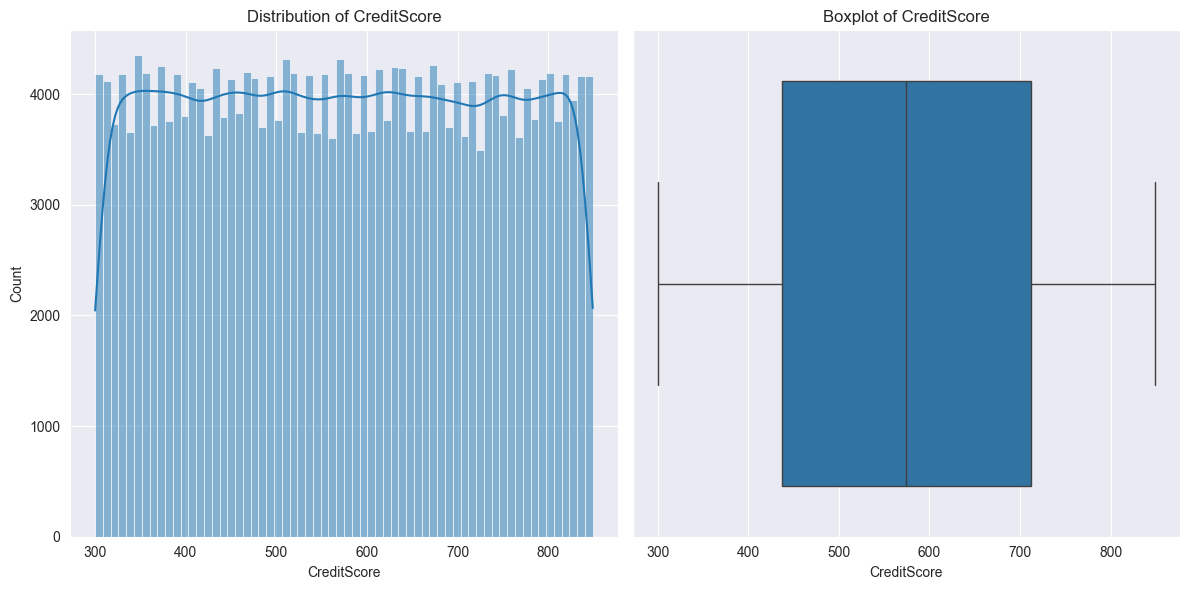

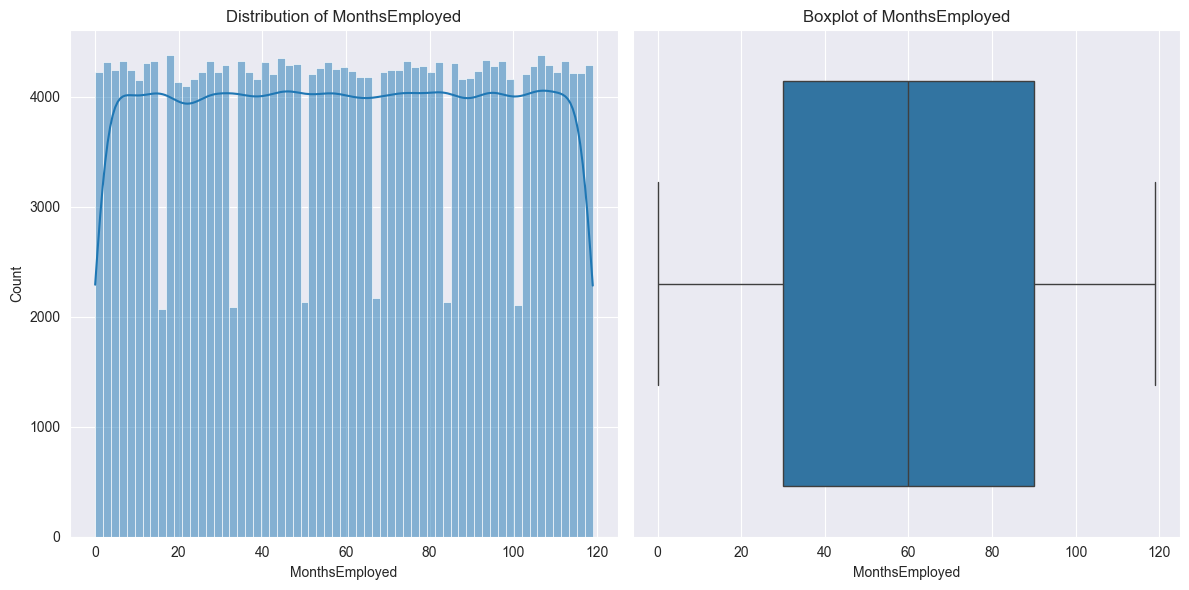

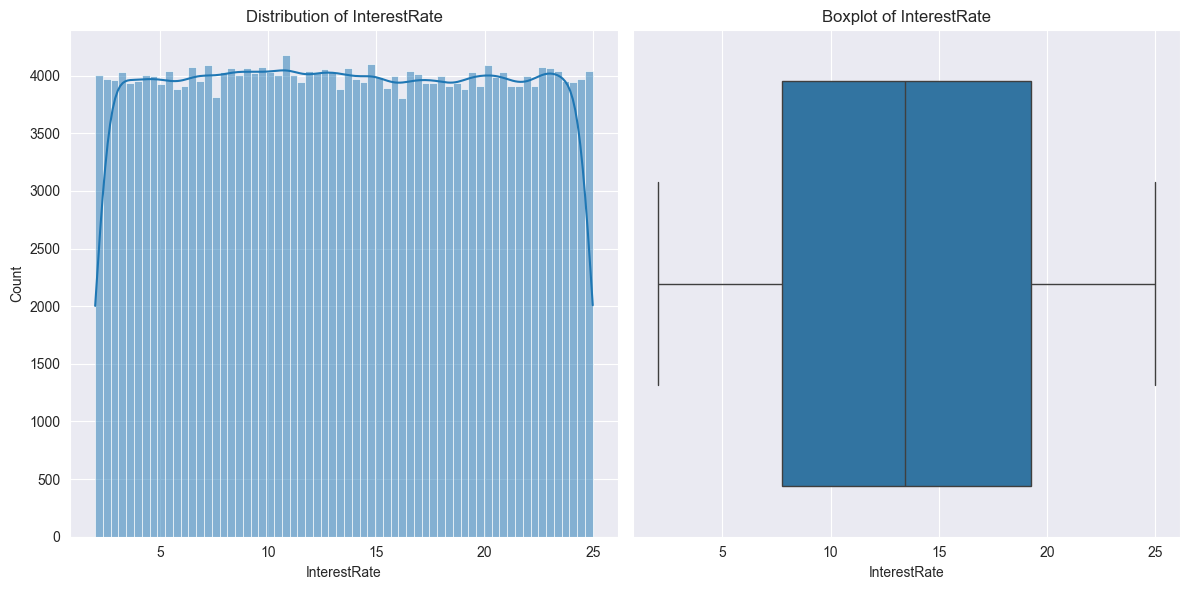

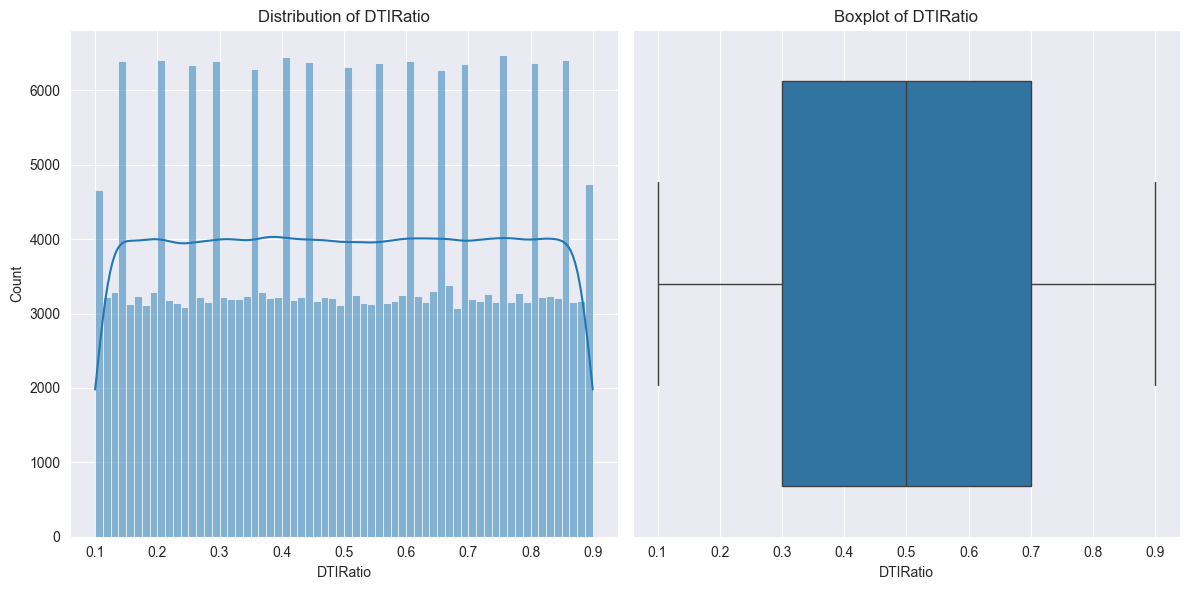

Discrete Variables Analysis:


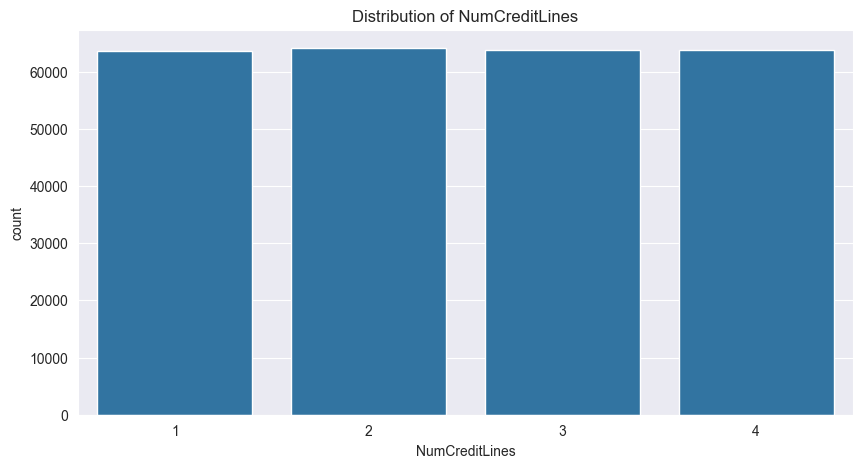

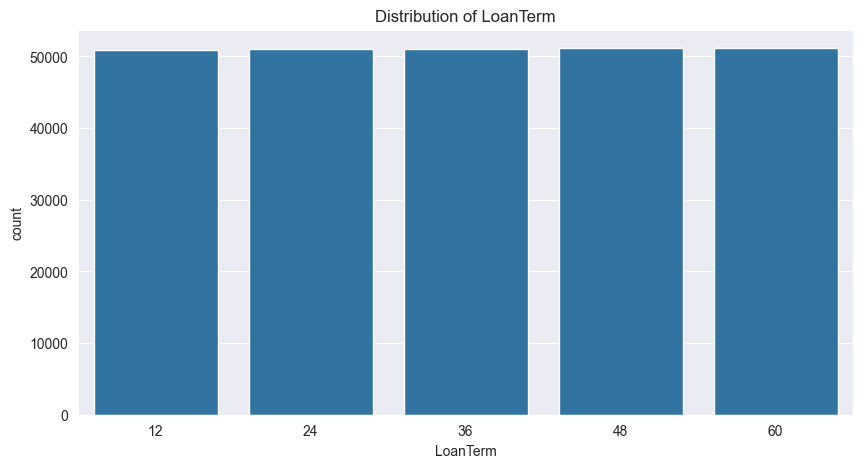

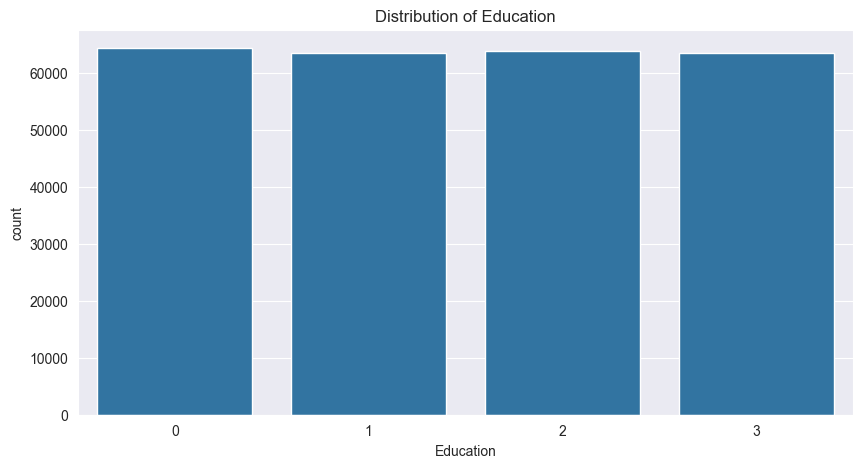

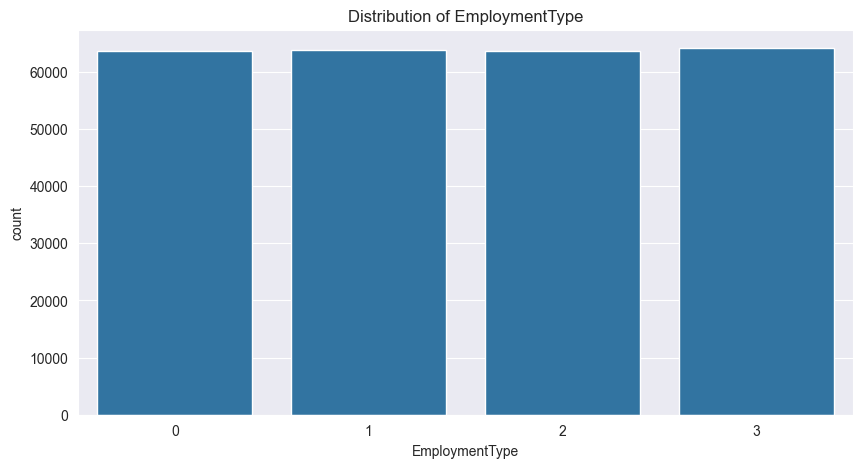

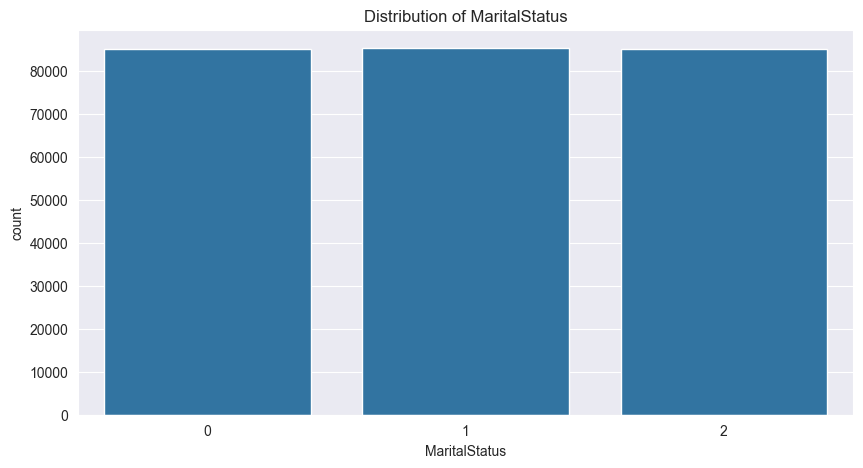

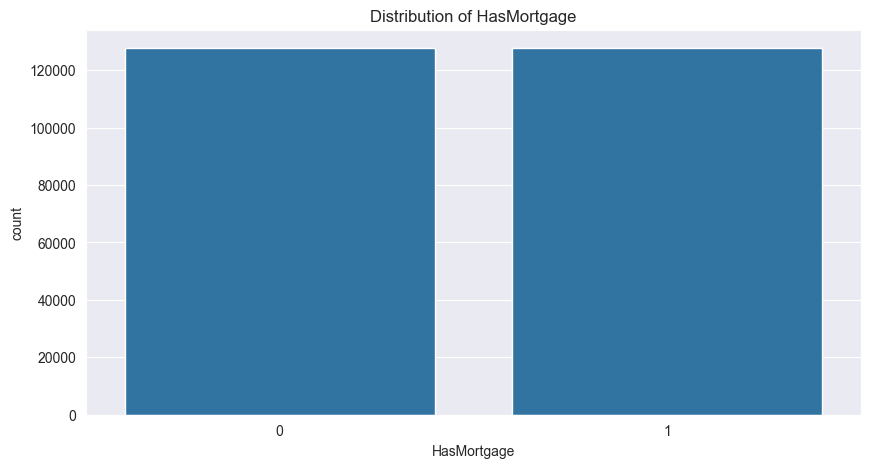

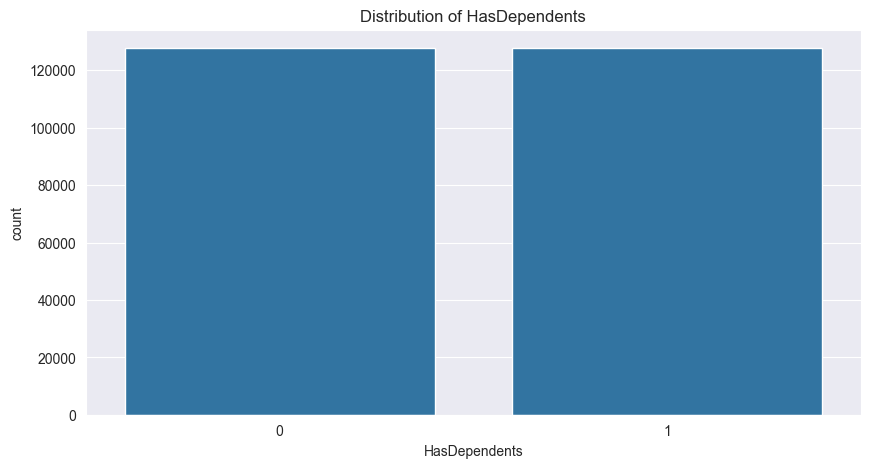

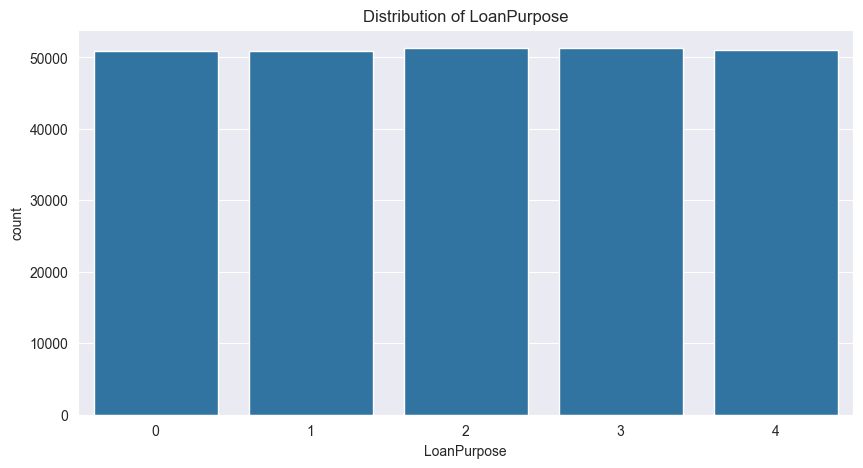

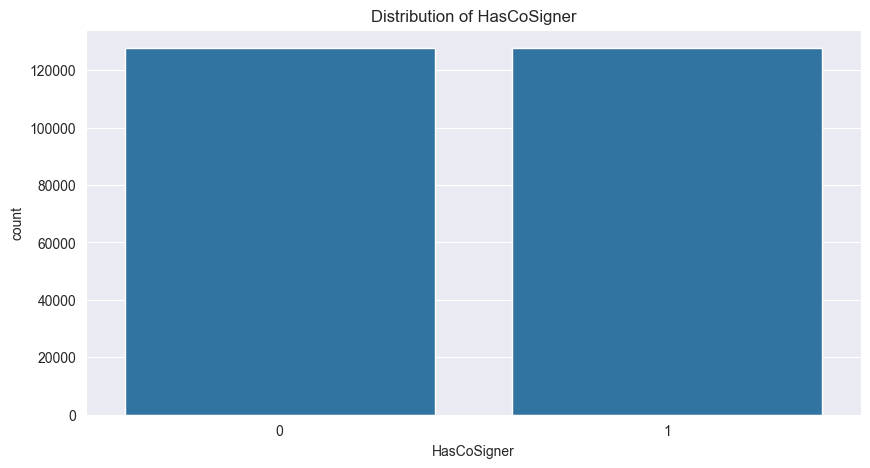

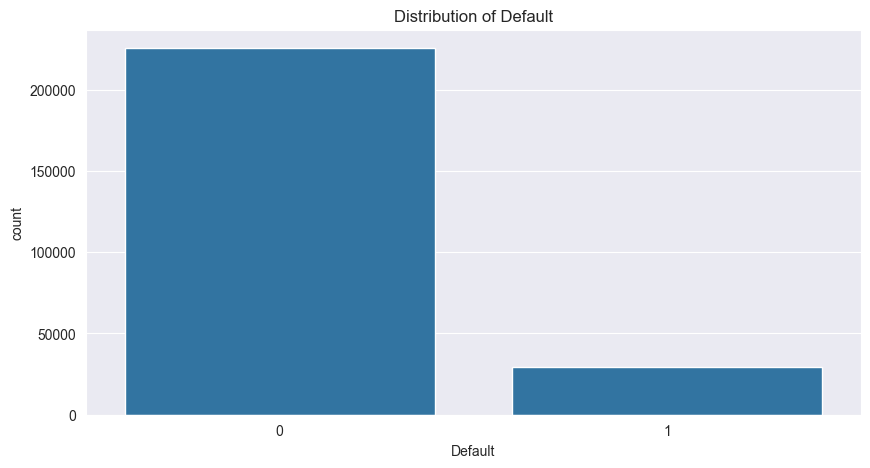

Variance Inflation Factor (VIF) for each feature:
           Feature       VIF
1              Age  1.030550
2           Income  1.010683
3       LoanAmount  1.008200
4      CreditScore  1.001352
5   MonthsEmployed  1.010335
6   NumCreditLines  1.000889
7     InterestRate  1.018657
8         LoanTerm  1.000036
9         DTIRatio  1.000436
10       Education  1.000193
11  EmploymentType  1.000411
12   MaritalStatus  1.000168
13     HasMortgage  1.000595
14   HasDependents  1.001335
15     LoanPurpose  1.000138
16     HasCoSigner  1.001754
17         Default  1.084909


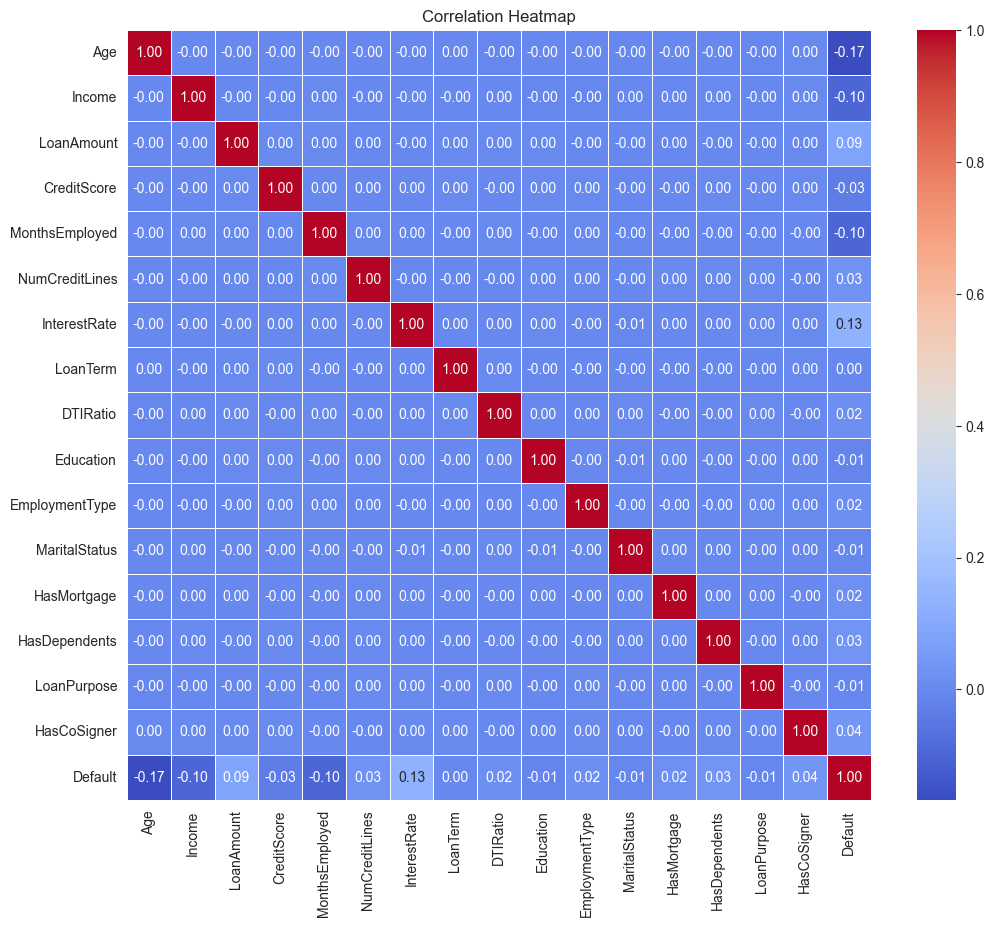

In [8]:


class EDA:
    def __init__(self, data_file: str, encoding_map_file: str):
        """
        Initialize the EDA with the path to the data CSV file and the encoding map JSON file.
        
        Args:
        data_file (str): Path to the input CSV file.
        encoding_map_file (str): Path to the JSON file with encoding maps for categorical variables.
        """
        self.df = pd.read_csv(data_file)
        with open(encoding_map_file, 'r') as f:
            self.encoding_map = json.load(f)
    
    def univariate_analysis(self):
        """
        Perform univariate analysis for continuous and discrete variables, excluding categorical variables.
        """
        # Get numerical columns (continuous and discrete)
        numerical_cols = self.df.select_dtypes(include=['number']).columns
        
        # Separate continuous and discrete columns
        continuous_cols = [col for col in numerical_cols if self.df[col].nunique() > 10]
        discrete_cols = [col for col in numerical_cols if self.df[col].nunique() <= 10]
        
        print("Continuous Variables Analysis:")
        for col in continuous_cols:
            plt.figure(figsize=(12, 6))
            plt.subplot(1, 2, 1)
            sns.histplot(self.df[col], kde=True)
            plt.title(f'Distribution of {col}')
            
            plt.subplot(1, 2, 2)
            sns.boxplot(x=self.df[col])
            plt.title(f'Boxplot of {col}')
            
            plt.tight_layout()
            plt.show()
        
        print("Discrete Variables Analysis:")
        for col in discrete_cols:
            plt.figure(figsize=(10, 5))
            sns.countplot(x=self.df[col])
            plt.title(f'Distribution of {col}')
            plt.show()
    
    def calculate_vif(self):
        """
        Calculate the Variance Inflation Factor (VIF) for each numerical feature in the DataFrame.
        
        Returns:
        pd.DataFrame: A DataFrame with the VIF values for each feature.
        """
        # Adding a constant column to the DataFrame for VIF calculation
        X = add_constant(self.df.select_dtypes(include=['number']))
        
        # Calculate VIF for each feature
        vif_data = pd.DataFrame()
        vif_data["Feature"] = X.columns
        vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
        
        # Drop the constant term from the result
        vif_data = vif_data[vif_data["Feature"] != "const"]
        
        return vif_data

    def bivariate_analysis(self):
        """
        Perform bivariate analysis by calculating and displaying the correlation heatmap.
        """
        # Create a DataFrame with only numerical columns for correlation analysis
        df_numerical = self.df.select_dtypes(include=['number'])
        # Calculate correlation matrix
        corr_matrix = df_numerical.corr()
        
        plt.figure(figsize=(12, 10))
        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
        plt.title('Correlation Heatmap')
        plt.show()

    def preprocess_and_analyze(self):
        """
        Perform preprocessing and analysis tasks including VIF calculation and univariate/bivariate analysis.
        """
        # Perform univariate analysis (excluding categorical variables)
        self.univariate_analysis()
        
        # Calculate and display VIF
        vif_df = self.calculate_vif()
        print("Variance Inflation Factor (VIF) for each feature:")
        print(vif_df)
        
        # Perform bivariate analysis
        self.bivariate_analysis()


if __name__ == "__main__":
    # Define file paths
    data_file_path = 'data/loans_cleaned.csv'
    encoding_map_file_path = 'data/encoding_map.json'
    
    # Create an EDA instance
    eda = EDA(data_file_path, encoding_map_file_path)
    
    # Perform preprocessing and analysis
    eda.preprocess_and_analyze()


### Observations on Dataset Features and Multicollinearity

In this section, we provide a comprehensive analysis of the dataset's features, focusing on their distributions and potential multicollinearity issues as indicated by the Variance Inflation Factor (VIF). Understanding these aspects is crucial for ensuring the stability and interpretability of our model.

#### Numerical Features:

1. **Age**:
   - **Range**: 18 to 69 years old.
   - **Mean**: 43.5 years.
   - **Distribution**: Ages are relatively evenly spread across adulthood, with a slight concentration around the 40–50 age range.
   - **VIF**: 1.030550
     - **Explanation**: The low VIF for Age suggests minimal multicollinearity with other features, indicating that Age is a stable and independent predictor in the model.

2. **Income**:
   - **Range**: 15,000 to 149,999.
   - **Mean**: 82,500.
   - **Distribution**: Most incomes are clustered in the middle range, with fewer individuals at the extremes.
   - **VIF**: 1.010683
     - **Explanation**: The very low VIF indicates that Income is not significantly correlated with other predictors, ensuring its stability as a feature in the model.

3. **LoanAmount**:
   - **Range**: 5,000 to 249,999.
   - **Mean**: 127,579.
   - **Distribution**: Loan amounts tend to cluster around mid-sized loans, with notable outliers at both ends.
   - **VIF**: 1.008200
     - **Explanation**: LoanAmount’s low VIF signifies that it does not suffer from high multicollinearity, making it a reliable predictor.

4. **CreditScore**:
   - **Range**: 300 to 849.
   - **Mean**: 574.
   - **Distribution**: Most credit scores are on the lower end (500–600), with fewer high scores.
   - **VIF**: 1.001352
     - **Explanation**: With a VIF close to 1, CreditScore shows minimal multicollinearity, supporting its role as a stable feature in the model.

5. **MonthsEmployed**:
   - **Range**: 0 to 119 months.
   - **Mean**: 59.5 months (approximately 5 years).
   - **Distribution**: Employment tenure skews toward shorter durations, with many employed for fewer than 5 years.
   - **VIF**: 1.010335
     - **Explanation**: The low VIF indicates that MonthsEmployed has minimal multicollinearity, ensuring it is a stable predictor in the model.

6. **NumCreditLines**:
   - **Range**: 1 to 4 credit lines.
   - **Mean**: 2.5 credit lines.
   - **Distribution**: Most individuals have between 2 and 3 credit lines.
   - **VIF**: 1.000889
     - **Explanation**: The very low VIF suggests that NumCreditLines is nearly independent of other features, which supports its stability.

7. **InterestRate**:
   - **Range**: 2% to 25%.
   - **Mean**: 13.5%.
   - **Distribution**: Interest rates are mostly between 10% and 20%, with fewer extreme values.
   - **VIF**: 1.018657
     - **Explanation**: InterestRate’s low VIF indicates it is minimally affected by multicollinearity, making it a stable feature.

8. **LoanTerm**:
   - **Range**: 12 to 60 months.
   - **Mean**: 36 months (3 years).
   - **Distribution**: Loan terms range from short (12 months) to long (60 months), with a concentration around 36 months.
   - **VIF**: 1.000036
     - **Explanation**: The extremely low VIF for LoanTerm indicates minimal multicollinearity, ensuring its stability in the model.

9. **DTIRatio (Debt-to-Income Ratio)**:
   - **Range**: 0.1 to 0.9.
   - **Mean**: 0.5.
   - **Distribution**: Most borrowers have a DTI ratio around 0.5, meaning they spend about half of their income on debt repayment.
   - **VIF**: 1.000436
     - **Explanation**: The low VIF suggests that DTIRatio is not significantly correlated with other features, supporting its stability.

#### Categorical Features:

1. **Education**:
   - **Categories**: "High School", "Associate's", "Bachelor's", "Master's/PhD".
   - **Most Common**: "Bachelor's".
   - **Distribution**: The distribution is fairly even, with a slight dominance of Bachelor's degrees.
   - **VIF**: 1.000193
     - **Explanation**: The very low VIF indicates minimal multicollinearity with other features, making Education a stable feature in the model.

2. **EmploymentType**:
   - **Categories**: "Full-time", "Part-time", "Self-employed", "Unemployed".
   - **Most Common**: "Part-time".
   - **Distribution**: A sizable portion is part-time employed, followed by full-time and self-employed individuals.
   - **VIF**: 1.000411
     - **Explanation**: The low VIF suggests EmploymentType is independent of other predictors, ensuring its stability.

3. **MaritalStatus**:
   - **Categories**: "Single", "Married", "Divorced".
   - **Most Common**: "Married".
   - **Distribution**: Most individuals are married, followed by singles and a smaller group of divorced individuals.
   - **VIF**: 1.000168
     - **Explanation**: The extremely low VIF indicates MaritalStatus is almost independent of other features, supporting its inclusion in the model.

4. **HasMortgage**:
   - **Categories**: "Yes", "No".
   - **Most Common**: "Yes".
   - **Distribution**: A majority of borrowers have a mortgage.
   - **VIF**: 1.000595
     - **Explanation**: The low VIF indicates minimal multicollinearity with other features, ensuring HasMortgage remains a stable predictor.

5. **HasDependents**:
   - **Categories**: "Yes", "No".
   - **Most Common**: "Yes".
   - **Distribution**: Most borrowers have dependents.
   - **VIF**: 1.001335
     - **Explanation**: HasDependents shows low multicollinearity with other features, indicating stability as a predictor.

6. **LoanPurpose**:
   - **Categories**: "Business", "Home Improvement", "Debt Consolidation", "Car Purchase", "Other".
   - **Most Common**: "Business".
   - **Distribution**: Business loans are the most common, followed by home improvement and debt consolidation.
   - **VIF**: 1.000138
     - **Explanation**: The very low VIF suggests LoanPurpose is independent of other predictors, making it a stable feature.

7. **HasCoSigner**:
   - **Categories**: "Yes", "No".
   - **Most Common**: "Yes".
   - **Distribution**: A significant portion of loans have a co-signer.
   - **VIF**: 1.001754
     - **Explanation**: While slightly higher, the VIF for HasCoSigner remains within acceptable limits, indicating minimal multicollinearity and ensuring stability.

8. **Default**:
   - **Categories**: "Yes", "No".
   - **Most Common**: "No".
   - **Distribution**: About 11.6% of the dataset defaults on their loans.
   - **VIF**: 1.084909
     - **Explanation**: Default has the highest VIF among features but is still below the problematic threshold of 10. This suggests some degree of multicollinearity, but it is not severe and the feature remains usable.

### Key Takeaways:
- **Overall Stability**: Most features exhibit very low VIF values, indicating that multicollinearity is not a significant issue, which helps maintain the stability of the model’s coefficients.
- **Independent Predictors**: Features such as Age, Income, and CreditScore contribute independently to the model, enhancing its interpretability.
- **Potential Issue**: Default has a higher VIF, but it remains within acceptable limits. While it shows some multicollinearity, it does not critically undermine the model’s stability.




---

### **Modeling Process**

#### 1. **Initialization**

- **Loading Data**: The pipeline begins by loading the dataset from a specified CSV file into a DataFrame using `pandas`. This dataset includes various features related to loan applications and their outcomes (defaults).

- **Defining Features**:
  - **Target Variable**: We set the target variable as `'Default'`, which indicates whether a loan has defaulted.
  - **Categorical Features**: A list of categorical features is defined. These features include `HasCoSigner`, `LoanPurpose`, `HasDependents`, `HasMortgage`, `MaritalStatus`, `EmploymentType`, and `Education`. These features need to be converted into a format suitable for machine learning models.
  - **Numerical Features**: We derived numerical features by excluding the target variable and the categorical features from the list of columns in the DataFrame.

- **Data Splitting**: We split the data into training and testing sets using `train_test_split` from `sklearn`. This process is done with:
  - `test_size=0.3` to allocate 30% of the data to the test set and 70% to the training set.
  - `random_state=42` to ensure reproducibility.
  - `stratify=self.y` to maintain the proportion of default and non-default cases in both the training and testing sets, which is crucial for dealing with class imbalance.

- **Directory Creation**: We checked if a directory named `'models'` exists and created it if it doesn’t. This directory will be used to save the trained models.

#### 2. **Data Preprocessing**

- **One-Hot Encoding**:
  - **Purpose**: Converts categorical features into numerical format by creating binary columns for each category. This transformation is essential because machine learning models require numerical inputs.
  - **Implementation**: We used `pd.get_dummies` to perform one-hot encoding on both the training and testing sets. This process converts categorical variables into a series of binary columns.

- **Aligning Columns**:
  - **Purpose**: Ensures that the training and test sets have the same feature columns after one-hot encoding. Any columns present in the training set but not in the test set are filled with zeros.
  - **Implementation**: `self.X_test_encoded = self.X_test_encoded.reindex(columns=self.X_train_encoded.columns, fill_value=0)` ensures consistency between training and testing feature sets.

- **Feature Scaling**:
  - **Purpose**: Standardizes the range of feature values to improve model performance, particularly for models sensitive to feature scaling, such as logistic regression.
  - **Implementation**: We used `MinMaxScaler` from `sklearn`, which scales features to a range of [0, 1]. The scaler was fit on the training set and applied to both training and test sets.

- **Class Imbalance Handling**:
  - **Purpose**: Addresses the imbalance between the classes in the target variable to improve model performance. In this case, the minority class (defaults) is oversampled or the majority class (non-defaults) is undersampled.
  - **Implementation**: We used `RandomUnderSampler` from `imblearn` to undersample the majority class in the training set, ensuring a balanced dataset for training.

#### 3. **Model Building**

- **Hyperparameter Tuning**:
  - **Purpose**: Optimizes model performance by finding the best combination of hyperparameters.
  - **Implementation**: We used `GridSearchCV` from `sklearn` for:
    - **Logistic Regression**: Grid search over penalties, regularization strengths, and solvers.
    - **Random Forest**: Grid search over number of estimators, maximum depth, minimum samples for splits and leaves, and class weights.
    - **CatBoost**: Grid search over number of iterations, depth, and regularization parameters.

- **Handling Class Imbalance for CatBoost**:
  - **Purpose**: CatBoost requires handling class imbalance differently due to its gradient boosting nature.
  - **Implementation**: We used `SMOTE` (Synthetic Minority Over-sampling Technique) to create synthetic samples for the minority class, balancing the dataset before training CatBoost.

- **Stacking Classifier**:
  - **Purpose**: Combines the predictions of multiple models to improve overall performance.
  - **Implementation**: We built a `StackingClassifier` using:
    - Base models: The best-performing Logistic Regression, Random Forest, and CatBoost models.
    - Final estimator: A logistic regression model that aggregates the predictions from the base models.

#### 4. **Model Evaluation**

- **Performance Metrics**:
  - **Purpose**: Evaluate the models’ performance using several metrics.
  - **Implementation**: For each model, we:
    - **Classification Report**: Generated a detailed classification report including precision, recall, and F1-score using `classification_report`.
    - **Confusion Matrix**: Computed and visualized the confusion matrix to assess the counts of true positives, true negatives, false positives, and false negatives.
    - **ROC Curve**: Plotted the ROC curve to visualize the trade-off between true positive rate and false positive rate, and computed the AUC (Area Under the Curve) to quantify model performance.

- **Meta-Model Evaluation**:
  - **Purpose**: Evaluate the performance of the stacking classifier that aggregates predictions from the base models.
  - **Implementation**: Similar to individual models, we generated a classification report, confusion matrix, and ROC curve for the meta-model.

#### 5. **Model Saving**

- **Purpose**: Persist trained models to disk for future use without retraining.
- **Implementation**: We used `pickle` to save each model and the meta-model into separate files within the `'models'` directory.

#### 6. **Executing the Pipeline**

- **Purpose**: Execute the complete pipeline from preprocessing to model saving.
- **Implementation**: The `run_pipeline` method sequentially performs data preprocessing, model building, evaluation, and saving, ensuring a comprehensive workflow for model development.

---


Model: Logistic Regression
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.68      0.79     67709
           1       0.22      0.70      0.34      8896

    accuracy                           0.68     76605
   macro avg       0.58      0.69      0.56     76605
weighted avg       0.86      0.68      0.74     76605



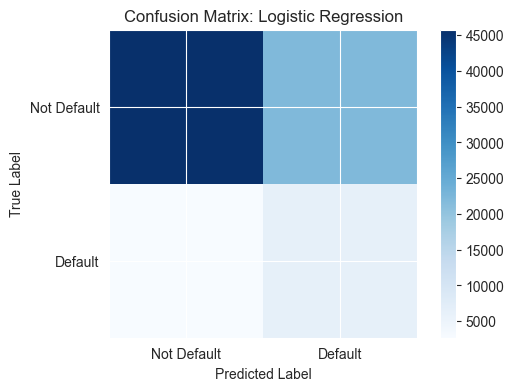

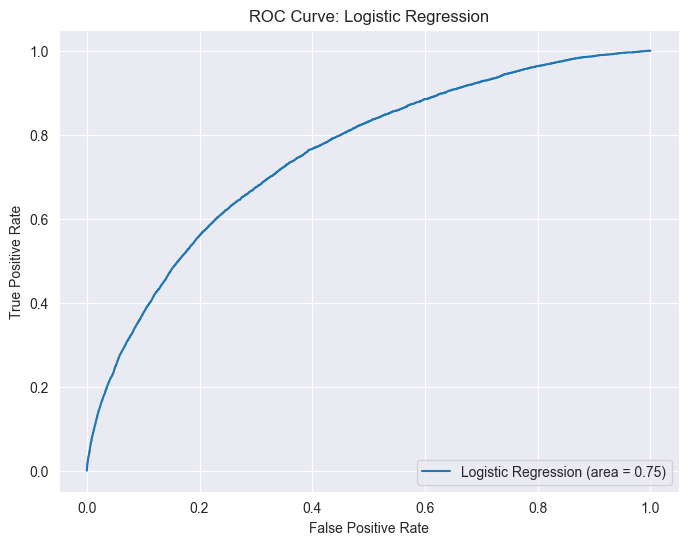

Model: Random Forest
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.69      0.79     67709
           1       0.22      0.69      0.34      8896

    accuracy                           0.69     76605
   macro avg       0.58      0.69      0.57     76605
weighted avg       0.86      0.69      0.74     76605



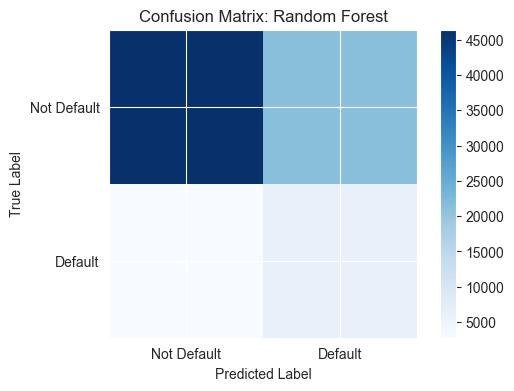

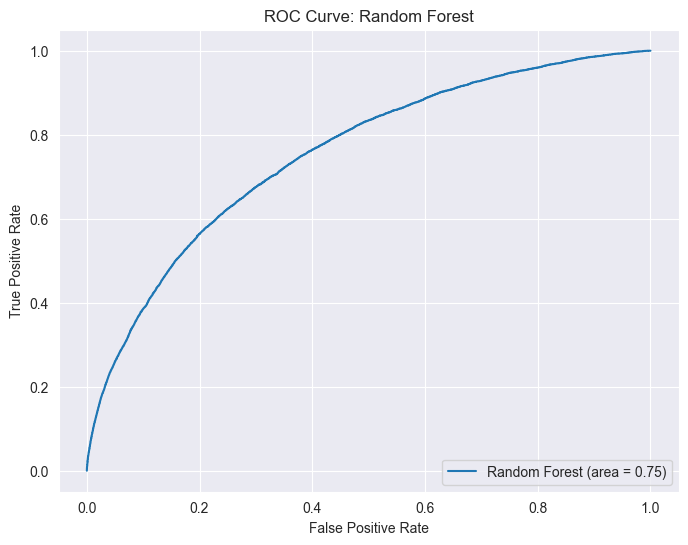

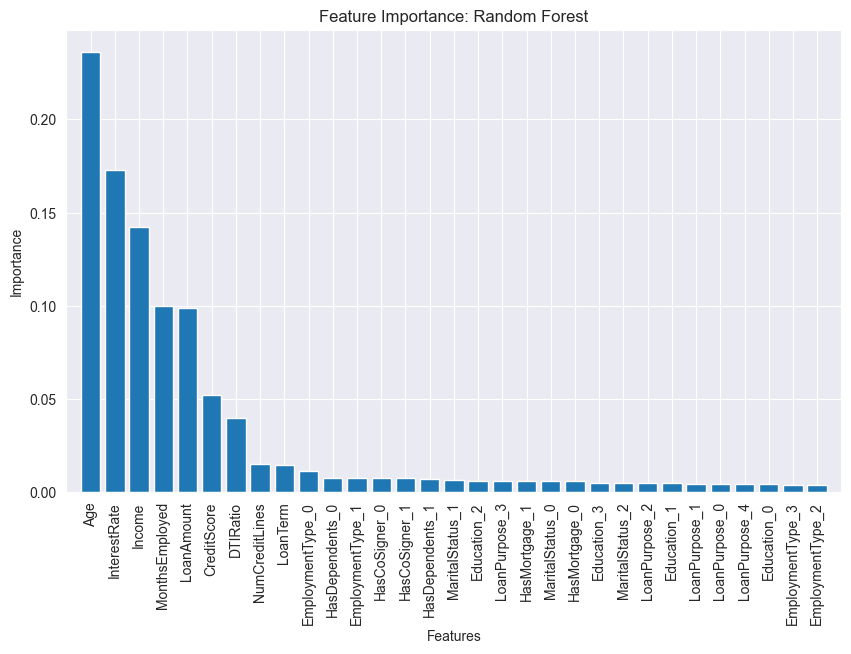

Model: CatBoost
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.99      0.94     67709
           1       0.57      0.09      0.15      8896

    accuracy                           0.89     76605
   macro avg       0.73      0.54      0.55     76605
weighted avg       0.85      0.89      0.85     76605



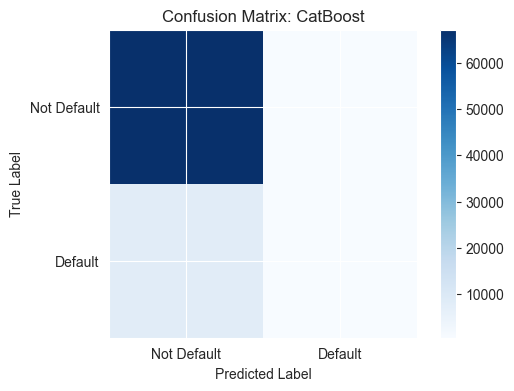

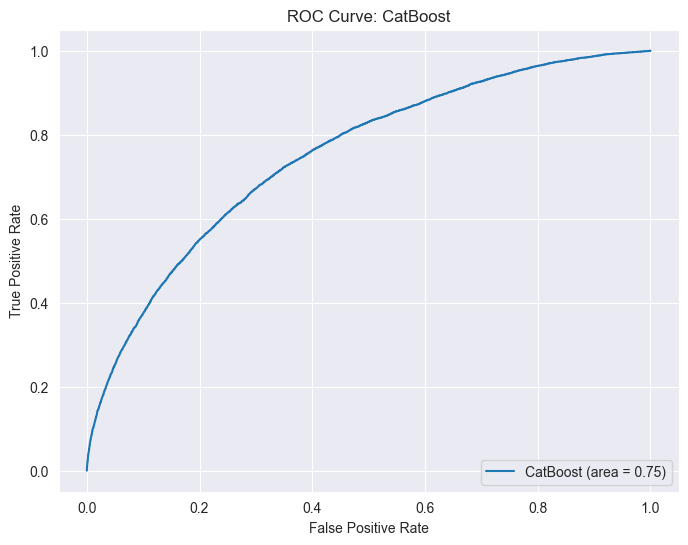

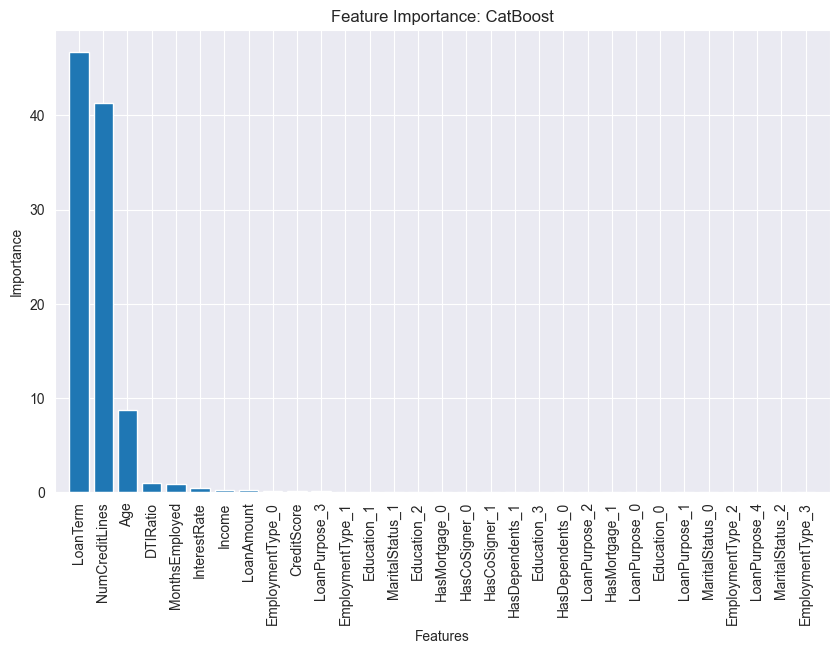

Meta-Model Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.69      0.80     67709
           1       0.23      0.69      0.34      8896

    accuracy                           0.69     76605
   macro avg       0.59      0.69      0.57     76605
weighted avg       0.86      0.69      0.74     76605



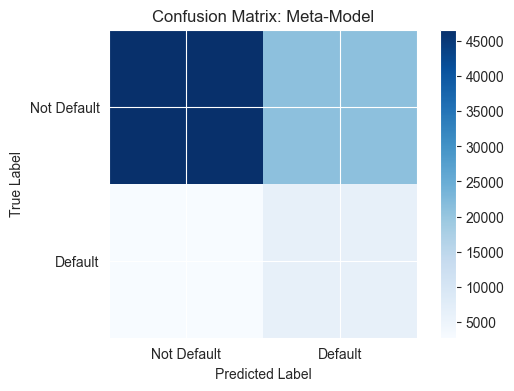

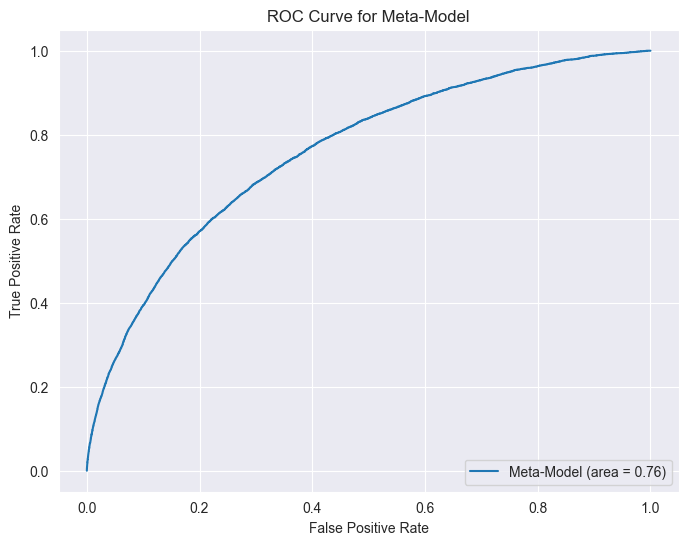

Models have been saved.


In [19]:


class ModelPipeline:
    def __init__(self, data_file: str):
        """
        Initialize the pipeline with the data CSV file.
        """
        self.df = pd.read_csv(data_file)
        
        # Define target and features
        self.target = 'Default'
        self.categorical_features = ["HasCoSigner", "LoanPurpose", "HasDependents", "HasMortgage", 
                                     "MaritalStatus", "EmploymentType", "Education"]
        self.numerical_features = [col for col in self.df.columns if col not in self.categorical_features + [self.target]]
        
        # Split data and ensure target is dropped from features
        self.X = self.df.drop(columns=[self.target])  # Drop the target from features
        self.y = self.df[self.target]
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            self.X, self.y, test_size=0.3, random_state=42, stratify=self.y
        )
        
        # Create directories for saving models
        if not os.path.exists('models'):
            os.makedirs('models')

    def preprocess(self):
        """
        Preprocess the data including one-hot encoding, scaling, and handling class imbalance.
        """
        # One-hot encoding for specified columns
        self.X_train_encoded = pd.get_dummies(self.X_train, columns=self.categorical_features)
        self.X_test_encoded = pd.get_dummies(self.X_test, columns=self.categorical_features)

        # Align columns in test set with those in training set
        self.X_test_encoded = self.X_test_encoded.reindex(columns=self.X_train_encoded.columns, fill_value=0)

        # Scale features using MinMaxScaler
        scaler = MinMaxScaler()
        self.X_train_scaled = scaler.fit_transform(self.X_train_encoded)
        self.X_test_scaled = scaler.transform(self.X_test_encoded)

        # Undersample for class imbalance
        undersampler = RandomUnderSampler(sampling_strategy=1, random_state=42)
        self.X_train_balanced, self.y_train_balanced = undersampler.fit_resample(self.X_train_scaled, self.y_train)

    def build_models(self):
        """
        Build and train models with the provided parameters.
        """
        # Logistic Regression
        self.logistic_regression = LogisticRegression(
            C=0.1, class_weight='balanced', max_iter=500, penalty='l2', solver='lbfgs'
        )
        self.logistic_regression.fit(self.X_train_balanced, self.y_train_balanced)

        # Random Forest
        self.random_forest = RandomForestClassifier(
            n_estimators=200, max_depth=10, min_samples_split=5, min_samples_leaf=2, class_weight='balanced', random_state=42
        )
        self.random_forest.fit(self.X_train_balanced, self.y_train_balanced)

        # CatBoost
        smote = SMOTE(sampling_strategy=1, random_state=42)
        X_smote, y_smote = smote.fit_resample(self.X_train_scaled, self.y_train)
        self.catboost = CatBoostClassifier(depth=6, iterations=400, l2_leaf_reg=1, silent=True, random_seed=42)
        self.catboost.fit(X_smote, y_smote)

        # Meta-model (Stacking)
        self.meta_model = StackingClassifier(
            estimators=[
                ('logistic regression', self.logistic_regression),
                ('random forest', self.random_forest),
                ('catboost', self.catboost)
            ],
            final_estimator=LogisticRegression(penalty='l2', solver='lbfgs', max_iter=1000)
        )
        self.meta_model.fit(self.X_train_balanced, self.y_train_balanced)

    def evaluate_models(self):
        """
        Evaluate the models and display results, including confusion matrix plots.
        """
        self.evaluation_results = {}

        for name, model in zip(['Logistic Regression', 'Random Forest', 'CatBoost'], 
                               [self.logistic_regression, self.random_forest, self.catboost]):
            y_pred = model.predict(self.X_test_scaled)
            report = classification_report(self.y_test, y_pred, output_dict=True)
            self.evaluation_results[name] = report

            # Print classification report
            print(f"Model: {name}")
            print("Classification Report:")
            print(classification_report(self.y_test, y_pred))

            # Confusion matrix and plot
            cm = confusion_matrix(self.y_test, y_pred)
            plt.figure(figsize=(6, 4))
            plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
            plt.title(f'Confusion Matrix: {name}')
            plt.colorbar()
            plt.xticks([0, 1], ['Not Default', 'Default'])
            plt.yticks([0, 1], ['Not Default', 'Default'])
            plt.xlabel('Predicted Label')
            plt.ylabel('True Label')
            plt.show()

            # Plot ROC Curve
            fpr, tpr, _ = roc_curve(self.y_test, model.predict_proba(self.X_test_scaled)[:, 1])
            plt.figure(figsize=(8, 6))
            plt.plot(fpr, tpr, label=f'{name} (area = {auc(fpr, tpr):.2f})')
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title(f'ROC Curve: {name}')
            plt.legend(loc='lower right')
            plt.show()

            # Feature Importance Plot
            if hasattr(model, 'feature_importances_'):
                importances = model.feature_importances_
                indices = np.argsort(importances)[::-1]
                features = self.X_train_encoded.columns

                plt.figure(figsize=(10, 6))
                plt.title(f'Feature Importance: {name}')
                plt.bar(range(len(indices)), importances[indices], align='center')
                plt.xticks(range(len(indices)), features[indices], rotation=90)
                plt.xlim([-1, len(indices)])
                plt.xlabel('Features')
                plt.ylabel('Importance')
                plt.show()

        # Evaluate the meta-model
        y_meta_pred = self.meta_model.predict(self.X_test_scaled)
        meta_report = classification_report(self.y_test, y_meta_pred, output_dict=True)
        self.evaluation_results['Meta-Model'] = meta_report

        print("Meta-Model Classification Report:")
        print(classification_report(self.y_test, y_meta_pred))

        # Confusion matrix for meta-model
        cm_meta = confusion_matrix(self.y_test, y_meta_pred)
        plt.figure(figsize=(6, 4))
        plt.imshow(cm_meta, interpolation='nearest', cmap=plt.cm.Blues)
        plt.title('Confusion Matrix: Meta-Model')
        plt.colorbar()
        plt.xticks([0, 1], ['Not Default', 'Default'])
        plt.yticks([0, 1], ['Not Default', 'Default'])
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.show()

        # ROC Curve for meta-model
        fpr_meta, tpr_meta, _ = roc_curve(self.y_test, self.meta_model.predict_proba(self.X_test_scaled)[:, 1])
        plt.figure(figsize=(8, 6))
        plt.plot(fpr_meta, tpr_meta, label=f'Meta-Model (area = {auc(fpr_meta, tpr_meta):.2f})')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve for Meta-Model')
        plt.legend(loc='lower right')
        plt.show()

    def save_models(self):
        """
        Save all models and the meta-model to files.
        """
        for name, model in zip(['logistic_regression', 'random_forest', 'catboost'], 
                               [self.logistic_regression, self.random_forest, self.catboost]):
            with open(f'models/{name}_model.pkl', 'wb') as f:
                pickle.dump(model, f)

        with open('models/meta_model.pkl', 'wb') as f:
            pickle.dump(self.meta_model, f)

        print("Models have been saved.")

    def run_pipeline(self):
        """
        Execute the full pipeline: preprocess, build models, evaluate, and save models.
        """
        self.preprocess()
        self.build_models()
        self.evaluate_models()
        self.save_models()


if __name__ == "__main__":
    data_file_path = 'data/loans_cleaned.csv'
    model_pipeline = ModelPipeline(data_file_path)
    model_pipeline.run_pipeline()


### Summary of Model Performance

In evaluating the performance of several classification models, including Logistic Regression, Random Forest, CatBoost, and a Meta-Model, the following observations were made:

**1. Logistic Regression:**
- **Accuracy:** 68%
- **Class 0:** Precision of 0.94 and Recall of 0.68, resulting in an F1-score of 0.79. The model effectively identifies the majority class (Class 0) with high precision, but the recall indicates that it misses a significant portion of Class 0 instances.
- **Class 1:** Precision of 0.22 and Recall of 0.70, leading to an F1-score of 0.34. While the recall is relatively high, indicating that the model can identify a good proportion of Class 1 instances, the low precision suggests that many of these predictions are false positives.
- **Macro Average:** Precision of 0.58, Recall of 0.69, and F1-score of 0.56.
- **Weighted Average:** Precision of 0.86, Recall of 0.68, and F1-score of 0.74. The weighted average reflects the model's overall performance across both classes, highlighting the imbalance in precision and recall between the classes.

**2. Random Forest:**
- **Accuracy:** 69%
- **Class 0:** Precision of 0.94 and Recall of 0.69, with an F1-score of 0.79. The Random Forest model maintains high precision for Class 0, with a slightly improved recall compared to Logistic Regression.
- **Class 1:** Precision of 0.22 and Recall of 0.69, leading to an F1-score of 0.34. Similar to Logistic Regression, the model has high recall for Class 1 but struggles with precision, indicating a high rate of false positives.
- **Macro Average:** Precision of 0.58, Recall of 0.69, and F1-score of 0.57.
- **Weighted Average:** Precision of 0.86, Recall of 0.69, and F1-score of 0.74. The weighted averages reflect a similar pattern to Logistic Regression, emphasizing the model's proficiency with Class 0 and limitations with Class 1.

**3. CatBoost:**
- **Accuracy:** 89%
- **Class 0:** Precision of 0.89 and Recall of 0.99, resulting in an F1-score of 0.94. CatBoost excels in identifying Class 0, with very high recall and strong precision, indicating few false positives for this class.
- **Class 1:** Precision of 0.57 and Recall of 0.09, leading to an F1-score of 0.15. The model significantly underperforms for Class 1, with very low recall suggesting that it misses most Class 1 instances despite better precision.
- **Macro Average:** Precision of 0.73, Recall of 0.54, and F1-score of 0.55.
- **Weighted Average:** Precision of 0.85, Recall of 0.89, and F1-score of 0.85. The weighted averages indicate that while CatBoost is strong overall, its performance on Class 1 impacts the average metrics.

**4. Meta-Model:**
- **Accuracy:** 69%
- **Class 0:** Precision of 0.94 and Recall of 0.69, with an F1-score of 0.80. The Meta-Model performs similarly to the Random Forest and Logistic Regression for Class 0, maintaining high precision and moderate recall.
- **Class 1:** Precision of 0.23 and Recall of 0.69, resulting in an F1-score of 0.34. The Meta-Model shows similar performance to individual models for Class 1, with high recall but low precision.
- **Macro Average:** Precision of 0.59, Recall of 0.69, and F1-score of 0.57.
- **Weighted Average:** Precision of 0.86, Recall of 0.69, and F1-score of 0.74. These averages reflect consistent performance across models, highlighting the need for improvement in precision, particularly for Class 1.

**Overall Findings:**
- All models exhibit strong performance in identifying Class 0, with high precision and recall, but face challenges in detecting Class 1. Class 1 predictions often suffer from low precision and high false positive rates.
- CatBoost, despite its high accuracy and performance on Class 0, struggles with Class 1, underscoring the model's limitations in handling class imbalance effectively.
- The Meta-Model, combining predictions from individual models, does not significantly improve precision for Class 1 but maintains consistent performance across both classes.
- There is a clear need for strategies to enhance Class 1 precision and overall model performance, potentially through further tuning, advanced ensemble methods, or improved class imbalance handling techniques.

| Metric               | Logistic Regression | Random Forest | CatBoost   | Meta-Model |
|----------------------|----------------------|---------------|------------|------------|
| **Accuracy**         | 68%                  | 69%           | 89%        | 69%        |
| **Class 0 Precision**| 0.94                 | 0.94          | 0.89       | 0.94       |
| **Class 0 Recall**   | 0.68                 | 0.69          | 0.99       | 0.69       |
| **Class 0 F1-Score** | 0.79                 | 0.79          | 0.94       | 0.80       |
| **Class 1 Precision**| 0.22                 | 0.22          | 0.57       | 0.23       |
| **Class 1 Recall**   | 0.70                 | 0.69          | 0.09       | 0.69       |
| **Class 1 F1-Score** | 0.34                 | 0.34          | 0.15       | 0.34       |
| **Macro Avg Precision** | 0.58               | 0.58          | 0.73       | 0.59       |
| **Macro Avg Recall**| 0.69                 | 0.69          | 0.54       | 0.69       |
| **Macro Avg F1-Score**| 0.56                | 0.57          | 0.55       | 0.57       |
| **Weighted Avg Precision** | 0.86            | 0.86          | 0.85       | 0.86       |
| **Weighted Avg Recall** | 0.68               | 0.69          | 0.89       | 0.69       |
| **Weighted Avg F1-Score**| 0.74              | 0.74          | 0.85       | 0.74       |


### **Deployment Decision**

Based on the evaluation, we decided to deploy the **CatBoost** model for the following reasons:

**1. Superior Performance:**
   - **CatBoost** exhibited the highest overall performance, particularly excelling in predicting non-default cases. With an accuracy of 89% and an F1-score of 0.94 for non-default predictions, it demonstrated its effectiveness in accurately identifying the majority class. This is crucial for ensuring reliable predictions in practical scenarios where the majority class is predominant.

**2. Effective Handling of Categorical Features:**
   - The model's ability to handle categorical features internally without extensive preprocessing sets **CatBoost** apart. This capability simplifies the data preparation process, reducing the risk of errors and making the deployment more straightforward compared to models that require additional encoding steps.

**3. Robustness with Imbalanced Data:**
   - Although **CatBoost** shows room for improvement in predicting the minority class (defaults), its robust performance with the majority class and overall accuracy justifies its choice. The model's handling of imbalanced data can be enhanced with further techniques, but its strengths in other areas make it a strong candidate.

**4. Efficiency and Speed:**
   - **CatBoost** is known for its efficiency, offering fast training and prediction times. This characteristic is vital for deployment scenarios where response time is crucial, making **CatBoost** an optimal choice for applications requiring real-time predictions.

**5. Simplified Hyperparameter Tuning:**
   - Compared to other models like **Random Forest**, **CatBoost** generally requires less extensive hyperparameter tuning. Its performance with fewer adjustments makes it easier to deploy and maintain, aligning well with the requirements for a production environment.

